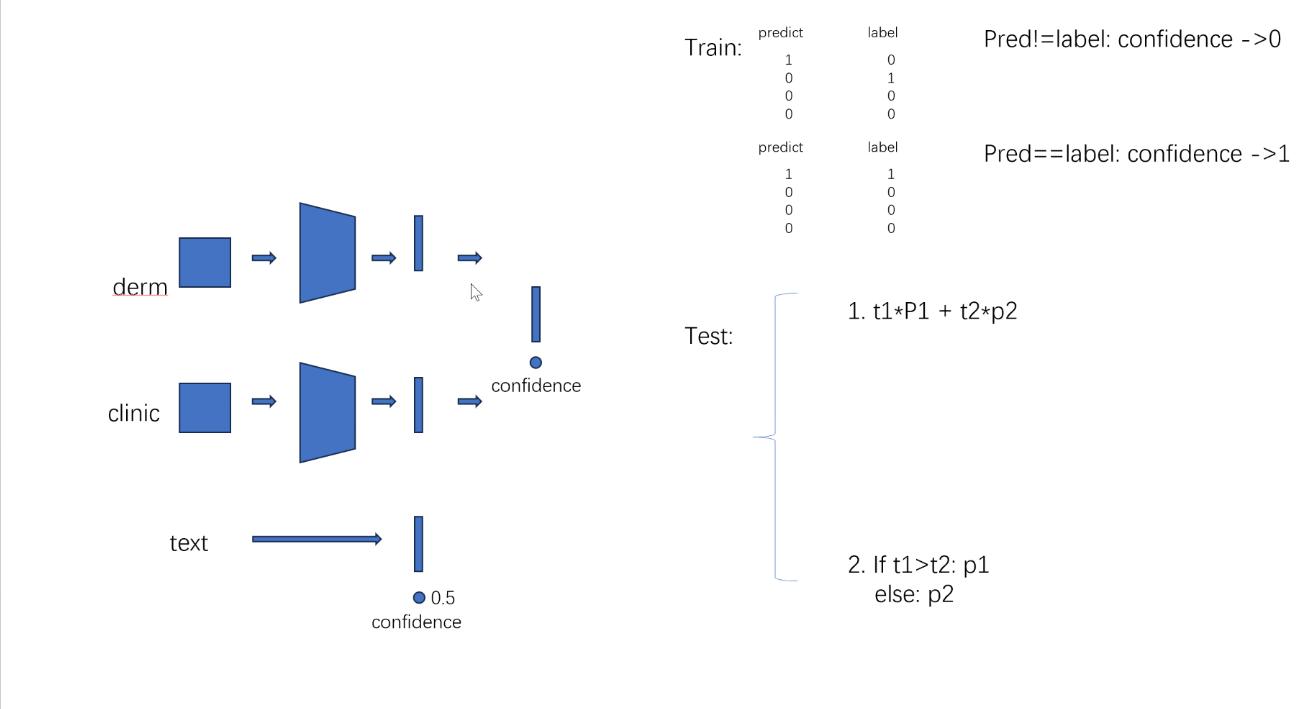

In [1]:
import torch.nn.functional as F
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score,accuracy_score, roc_curve,auc,average_precision_score,precision_recall_curve
import cv2
from dependency import *
import pandas as pd
from utils import encode_test_label,Logger,encode_meta_choosed_label,encode_meta_label
from tqdm import tqdm_notebook  

test_index_df = pd.read_csv(test_index_path)
train_index_df = pd.read_csv(train_index_path)
val_index_df = pd.read_csv(val_index_path)

train_index_list = list(train_index_df['indexes'])
val_index_list = list(val_index_df['indexes'])
test_index_list = list(test_index_df['indexes'])

train_index_list_1 = train_index_list[0:206]
train_index_list_2 = train_index_list[206:]

df = pd.read_csv(img_info_path)

In [2]:
from tensorflow.keras.utils import to_categorical
import pandas as pd
from dependency import *

In [3]:
def get_label_list(image_index_list):
    diag_label_list = []
    pn_label_list = []
    str_label_list = []
    pig_label_list = []
    rs_label_list = []
    dag_label_list = []
    bwv_label_list = []
    vs_label_list = []
    meta_list = []
    meta_list_one_hot = []
    
    img_feature = []
    img_hf_feature = []
    img_vf_feature = []
    img_vhf_feature = []

    from sklearn.decomposition import PCA

    from tqdm import tqdm_notebook,tqdm
    for index_num in tqdm(image_index_list):
    #index_num = test_index_list[100]
        img_info = df[index_num:index_num+1]
        clinic_path = img_info['clinic']
        dermoscopy_path = img_info['derm']
        source_dir = '../release_v0/release_v0/images/'
        clinic_img = cv2.imread(source_dir+clinic_path[index_num])
        dermoscopy_img = cv2.imread(source_dir+dermoscopy_path[index_num])
        '''这里对于metadata需要变更'''
        meta_vector_one_hot,meta_vector = encode_meta_choosed_label(img_info,index_num)
        
        [diagnosis_label,pigment_network_label,streaks_label,pigmentation_label,regression_structures_label,
         dots_and_globules_label,blue_whitish_veil_label, vascular_structures_label],[diagnosis_label_one_hot,pigment_network_label_one_hot,
        streaks_label_one_hot,pigmentation_label_one_hot,regression_structures_label_one_hot,
        dots_and_globules_label_one_hot,blue_whitish_veil_label_one_hot, vascular_structures_label_one_hot] = encode_test_label(img_info,index_num)

        diag_label_list.append(diagnosis_label)
        pn_label_list.append(pigment_network_label)
        str_label_list.append(streaks_label)
        pig_label_list.append(pigmentation_label)
        rs_label_list.append(regression_structures_label)
        dag_label_list.append(dots_and_globules_label)
        bwv_label_list.append(blue_whitish_veil_label)
        vs_label_list.append(vascular_structures_label)
        meta_list.append(meta_vector)
        meta_list_one_hot.append(meta_vector_one_hot)



    label_dict ={'diag':diag_label_list,
                 'pn':pn_label_list,
                 'str':str_label_list,
                 'pig':pig_label_list,
                 'rs':rs_label_list,
                 'dag':dag_label_list,
                 'bwv':bwv_label_list,
                 'vs':vs_label_list}
    
    return label_dict,meta_list,meta_list_one_hot

# multi-classification and regression

In [4]:
from model import Resnet_with_uncertainty
from second_stage_fusion_utils_concat2 import predict
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error 
import numpy as np
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib notebook

  0%|                                                                                          | 0/413 [00:00<?, ?it/s]E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\utils.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  vascular_structures_label_one_hot])
100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:04<00:00, 86.61it/s]


In [5]:
def multi_classifier_predict(test_meta_feature):
    forest = RandomForestClassifier(random_state = 1)
    clf = MultiOutputClassifier(forest, n_jobs = 2)
    meta_label = np.array([img_diag_label,img_pn_label,img_str_label,img_pig_label,img_rs_label,img_dag_label,img_bwv_label,img_vs_label]).T
    clf.fit(meta_total_feature_one_hot,meta_label)
    train_preds_all = clf.predict(meta_total_feature_one_hot)
    train_preds_prob_all = clf.predict_proba(meta_total_feature_one_hot)
    
    #preds labels
    diag_preds_train = train_preds_all[:,0]
    pn_preds_train = train_preds_all[:,1]
    str_preds_train = train_preds_all[:,2]
    pig_preds_train = train_preds_all[:,3]
    rs_preds_train = train_preds_all[:,4]
    dag_preds_train = train_preds_all[:,5]
    bwv_preds_train = train_preds_all[:,6]
    vs_preds_train = train_preds_all[:,7]
    diag_preds_train = torch.tensor(diag_preds_train)
    pn_preds_train = torch.tensor(pn_preds_train)
    str_preds_train = torch.tensor(str_preds_train)
    pig_preds_train = torch.tensor(pig_preds_train)
    rs_preds_train = torch.tensor(rs_preds_train)
    dag_preds_train = torch.tensor(dag_preds_train)
    bwv_preds_train = torch.tensor(bwv_preds_train)
    vs_preds_train = torch.tensor(vs_preds_train)
    
    diag_preds_train = diag_preds_train.unsqueeze(0)
    pn_preds_train = pn_preds_train.unsqueeze(0)
    str_preds_train = str_preds_train.unsqueeze(0)
    pig_preds_train = pig_preds_train.unsqueeze(0)
    rs_preds_train = rs_preds_train.unsqueeze(0)
    dag_preds_train = dag_preds_train.unsqueeze(0)
    bwv_preds_train = bwv_preds_train.unsqueeze(0)
    vs_preds_train = vs_preds_train.unsqueeze(0)
    
    #true labels
    img_diag_label_t = torch.tensor(img_diag_label).unsqueeze(0)
    img_pn_label_t = torch.tensor(img_pn_label).unsqueeze(0)
    img_str_label_t = torch.tensor(img_str_label).unsqueeze(0)
    img_pig_label_t = torch.tensor(img_pig_label).unsqueeze(0)
    img_rs_label_t = torch.tensor(img_rs_label).unsqueeze(0)
    img_dag_label_t = torch.tensor(img_dag_label).unsqueeze(0)
    img_bwv_label_t = torch.tensor(img_bwv_label).unsqueeze(0)
    img_vs_label_t = torch.tensor(img_vs_label).unsqueeze(0)
    
    img_diag_label_t = np.array(img_diag_label_t.cpu(),dtype="int")
    img_pn_label_t = np.array(img_pn_label_t.cpu(),dtype="int")
    img_str_label_t = np.array(img_str_label_t.cpu(),dtype="int")
    img_pig_label_t = np.array(img_pig_label_t.cpu(),dtype="int")
    img_rs_label_t = np.array(img_rs_label_t.cpu(),dtype="int")
    img_dag_label_t = np.array(img_dag_label_t.cpu(),dtype="int")
    img_bwv_label_t = np.array(img_bwv_label_t.cpu(),dtype="int")
    img_vs_label_t = np.array(img_vs_label_t.cpu(),dtype="int")
    
    diag_preds_train = np.array(diag_preds_train.cpu(),dtype="int")
    pn_preds_train = np.array(pn_preds_train.cpu(),dtype="int")
    str_preds_train = np.array(str_preds_train.cpu(),dtype="int")
    pig_preds_train = np.array(pig_preds_train.cpu(),dtype="int")
    rs_preds_train = np.array(rs_preds_train.cpu(),dtype="int")
    dag_preds_train = np.array(dag_preds_train.cpu(),dtype="int")
    bwv_preds_train = np.array(bwv_preds_train.cpu(),dtype="int")
    vs_preds_train = np.array(vs_preds_train.cpu(),dtype="int")
    
    t = np.hstack((img_diag_label_t.T,img_pn_label_t.T))
    t = np.hstack((t,img_str_label_t.T))
    t = np.hstack((t,img_pig_label_t.T))
    t = np.hstack((t,img_rs_label_t.T))
    t = np.hstack((t,img_dag_label_t.T))
    t = np.hstack((t,img_bwv_label_t.T))
    t = np.hstack((t,img_vs_label_t.T))
    t = torch.tensor(t)
    print("t.size:",t.size())
    p = np.hstack((diag_preds_train.T,pn_preds_train.T))
    p = np.hstack((p,str_preds_train.T))
    p = np.hstack((p,pig_preds_train.T))
    p = np.hstack((p,rs_preds_train.T))
    p = np.hstack((p,dag_preds_train.T))
    p = np.hstack((p,bwv_preds_train.T))
    p = np.hstack((p,vs_preds_train.T))
    p = torch.tensor(p)
    print("p.size:",p.size())
    certainty_b = (t == p).long()
    certainty_ones = torch.tensor(np.ones(certainty_b.size()))
    uncertainty_label_meta = []
    for i in range(certainty_ones.size(0)):
        uncertainty_label_meta.append([mean_squared_error(certainty_ones[i,:],certainty_b[i,:])])
    uncertainty_label_meta = torch.tensor(uncertainty_label_meta)
    uncertainty_label_meta = uncertainty_label_meta.float().cuda()
    uncertainty_label_meta = torch.squeeze(uncertainty_label_meta)
    print("uncertainty_label_meta.size:",uncertainty_label_meta.size())
    
    #Regression
    #train the regression model
    meta_total_feature_2 = np.array(torch.cat((torch.tensor(meta_total_feature),p),1))
    n_folds = 6
    model_br = BayesianRidge()
    model_lr = LinearRegression()
    model_etc = ElasticNet()
    model_svr = SVR()
    model_gbr = GradientBoostingRegressor()
    model_names = ['BayesianRidge','LinearRegression','ElasticNet','SVR','GBR']
    model_dic = [model_br,model_lr,model_etc,model_svr,model_gbr]
    cos_score_list = []
    pred_y_list = []
    for model in model_dic:
        scores = cross_val_score(model,meta_total_feature_2,uncertainty_label_meta.cpu(),cv = n_folds)
        cos_score_list.append(scores)
        pred_y_list.append(model.fit(meta_total_feature_2,uncertainty_label_meta.cpu()).predict(meta_total_feature_2))
    n_samples,n_features = meta_total_feature_2.shape
    print("n_samples:",n_samples)
    print("n_features:",n_features)
    model_metrics_names = [explained_variance_score, mean_squared_error, r2_score]
    model_metrics_list = []
    for i in range(len(model_names)):
        tmp_list = []
        for m in model_metrics_names:
            tmp_score = m(uncertainty_label_meta.cpu(),pred_y_list[i])
            tmp_list.append(tmp_score)
        model_metrics_list.append(tmp_list)
    df1 = pd.DataFrame(cos_score_list, index=model_names) 
    df2 = pd.DataFrame(model_metrics_list, index=model_names, columns=['ev', 'mse', 'r2'])  
    print (70 * '-')  
    print ('cross validation result:')  
    print (df1)  
    print (70 * '-')  
    print ('regression metrics:')  
    print (df2)  
    print (70 * '-')  
    # 
    plt.figure()  
    plt.plot(np.arange(meta_total_feature_2.shape[0]),uncertainty_label_meta.cpu() , color='k', label='true y')  
    color_list = ['r', 'b', 'g', 'y', 'c']  
    linestyle_list = ['-', '.', 'o', 'v', '*'] 
    for i, pre_y in enumerate(pred_y_list):  
        plt.plot(np.arange(meta_total_feature_2.shape[0]), pred_y_list[i], color_list[i], label=model_names[i])  
    plt.title('regression result comparison') 
    plt.legend(loc='upper right')  
    plt.ylabel('real and predicted value') 
    plt.show()  

    test_preds_all = clf.predict(test_meta_total_feature_one_hot)
    test_probs_all = clf.predict_proba(test_meta_total_feature_one_hot)
    diag_preds_test = test_preds_all[:,0]
    pn_preds_test = test_preds_all[:,1]
    str_preds_test = test_preds_all[:,2]
    pig_preds_test = test_preds_all[:,3]
    rs_preds_test = test_preds_all[:,4]
    dag_preds_test = test_preds_all[:,5]
    bwv_preds_test = test_preds_all[:,6]
    vs_preds_test = test_preds_all[:,7]
    diag_probs_test = np.array(test_probs_all[0])
    pn_probs_test = np.array(test_probs_all[1])
    str_probs_test = np.array(test_probs_all[2])
    pig_probs_test = np.array(test_probs_all[3])
    rs_probs_test = np.array(test_probs_all[4])
    dag_probs_test = np.array(test_probs_all[5])
    bwv_probs_test = np.array(test_probs_all[6])
    vs_probs_test = np.array(test_probs_all[7])
    
    diag_preds_test = torch.tensor(diag_preds_test)
    pn_preds_test = torch.tensor(pn_preds_test)
    str_preds_test = torch.tensor(str_preds_test)
    pig_preds_test = torch.tensor(pig_preds_test)
    rs_preds_test = torch.tensor(rs_preds_test)
    dag_preds_test = torch.tensor(dag_preds_test)
    bwv_preds_test = torch.tensor(bwv_preds_test)
    vs_preds_test = torch.tensor(vs_preds_test)
    
    diag_preds_test = diag_preds_test.unsqueeze(0)
    pn_preds_test = pn_preds_test.unsqueeze(0)
    str_preds_test = str_preds_test.unsqueeze(0)
    pig_preds_test = pig_preds_test.unsqueeze(0)
    rs_preds_test = rs_preds_test.unsqueeze(0)
    dag_preds_test = dag_preds_test.unsqueeze(0)
    bwv_preds_test = bwv_preds_test.unsqueeze(0)
    vs_preds_test = vs_preds_test.unsqueeze(0)
    
    diag_preds_test = np.array(diag_preds_test.cpu(),dtype="int")
    pn_preds_test = np.array(pn_preds_test.cpu(),dtype="int")
    str_preds_test = np.array(str_preds_test.cpu(),dtype="int")
    pig_preds_test = np.array(pig_preds_test.cpu(),dtype="int")
    rs_preds_test = np.array(rs_preds_test.cpu(),dtype="int")
    dag_preds_test = np.array(dag_preds_test.cpu(),dtype="int")
    bwv_preds_test = np.array(bwv_preds_test.cpu(),dtype="int")
    vs_preds_test = np.array(vs_preds_test.cpu(),dtype="int")
    
    p = np.hstack((diag_preds_test.T,pn_preds_test.T))
    p = np.hstack((p,str_preds_test.T))
    p = np.hstack((p,pig_preds_test.T))
    p = np.hstack((p,rs_preds_test.T))
    p = np.hstack((p,dag_preds_test.T))
    p = np.hstack((p,bwv_preds_test.T))
    p = np.hstack((p,vs_preds_test.T))
    p = torch.tensor(p)
    print("p.size:",p.size())
    test_meta_total_feature_2 = np.array(torch.cat((torch.tensor(test_meta_total_feature),p),1))
    uncertainty = model_gbr.predict(test_meta_total_feature_2)#bigger uncertainty, less accurate the prediction is.
    
    return [[diag_preds_test,pn_preds_test,str_preds_test,pig_preds_test,rs_preds_test,dag_preds_test,bwv_preds_test,vs_preds_test],
            [diag_probs_test,pn_probs_test,str_probs_test,pig_probs_test,rs_probs_test,dag_probs_test,bwv_probs_test,vs_probs_test],uncertainty] 

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
net = Resnet_with_uncertainty(class_list).cuda()
model_name = 'Resnet_cos-loss and concat'
mode = 'multimodal'
size = 229
TTA = 6
img_type="concat"
out_dir = './{}_{}_result/{}/'.format(mode,model_name, 0)

print("multi-modality with uncertainty(metadata)")
train_label_dict,train_meta_list,train_meta_list_one_hot = get_label_list(train_index_list)
val_label_dict,val_meta_list,val_meta_list_one_hot = get_label_list(val_index_list)
test_label_dict,test_meta_list,test_meta_list_one_hot = get_label_list(test_index_list)

train_meta_array = np.array(train_meta_list)
val_meta_array = np.array(val_meta_list)
test_meta_array = np.array(test_meta_list)
train_meta_array_one_hot = np.array(train_meta_list_one_hot)
val_meta_array_one_hot = np.array(val_meta_list_one_hot)
test_meta_array_one_hot = np.array(test_meta_list_one_hot)

meta_total_feature_one_hot = train_meta_array_one_hot
val_meta_total_feature_one_hot = val_meta_array_one_hot
test_meta_total_feature_one_hot = test_meta_array_one_hot
meta_total_feature = train_meta_array
val_meta_total_feature = val_meta_array
test_meta_total_feature = test_meta_array

train_diag_label = np.array(train_label_dict['diag'])
val_diag_label = np.array(val_label_dict['diag'])
test_diag_label = np.array(test_label_dict['diag'])

img_pn_label = np.array(train_label_dict['pn'])
img_str_label = np.array(train_label_dict['str'])
img_pig_label = np.array(train_label_dict['pig'])
img_rs_label = np.array(train_label_dict['rs'])
img_dag_label = np.array(train_label_dict['dag'])
img_bwv_label = np.array(train_label_dict['bwv'])
img_vs_label = np.array(train_label_dict['vs'])
img_diag_label = np.array(train_label_dict['diag'])

test_img_pn_label = np.array(test_label_dict['pn'])
test_img_str_label = np.array(test_label_dict['str'])
test_img_pig_label = np.array(test_label_dict['pig'])
test_img_rs_label = np.array(test_label_dict['rs'])
test_img_dag_label = np.array(test_label_dict['dag'])
test_img_bwv_label = np.array(test_label_dict['bwv'])
test_img_vs_label = np.array(test_label_dict['vs'])
test_img_diag_label = np.array(test_label_dict['diag'])

val_img_pn_label= np.array(val_label_dict['pn'])
val_img_str_label= np.array(val_label_dict['str'])
val_img_pig_label= np.array(val_label_dict['pig'])
val_img_rs_label= np.array(val_label_dict['rs'])
val_img_dag_label= np.array(val_label_dict['dag'])
val_img_bwv_label= np.array(val_label_dict['bwv'])
val_img_vs_label= np.array(val_label_dict['vs'])
val_img_diag_label= np.array(val_label_dict['diag'])

img_pn_label_one_hot = to_categorical(np.array(train_label_dict['pn']))
img_str_label_one_hot= to_categorical(np.array(train_label_dict['str']))
img_pig_label_one_hot= to_categorical(np.array(train_label_dict['pig']))
img_rs_label_one_hot= to_categorical(np.array(train_label_dict['rs']))
img_dag_label_one_hot= to_categorical(np.array(train_label_dict['dag']))
img_bwv_label_one_hot= to_categorical(np.array(train_label_dict['bwv']))
img_vs_label_one_hot= to_categorical(np.array(train_label_dict['vs']))
img_diag_label_one_hot = to_categorical(np.array(train_label_dict['diag']))

val_img_pn_label_one_hot = to_categorical(np.array(val_label_dict['pn']))
val_img_str_label_one_hot= to_categorical(np.array(val_label_dict['str']))
val_img_pig_label_one_hot= to_categorical(np.array(val_label_dict['pig']))
val_img_rs_label_one_hot= to_categorical(np.array(val_label_dict['rs']))
val_img_dag_label_one_hot= to_categorical(np.array(val_label_dict['dag']))
val_img_bwv_label_one_hot= to_categorical(np.array(val_label_dict['bwv']))
val_img_vs_label_one_hot= to_categorical(np.array(val_label_dict['vs']))
val_img_diag_label_one_hot = to_categorical(np.array(val_label_dict['diag']))

test_img_pn_label_one_hot = to_categorical(np.array(test_label_dict['pn']))
test_img_str_label_one_hot= to_categorical(np.array(test_label_dict['str']))
test_img_pig_label_one_hot= to_categorical(np.array(test_label_dict['pig']))
test_img_rs_label_one_hot= to_categorical(np.array(test_label_dict['rs']))
test_img_dag_label_one_hot= to_categorical(np.array(test_label_dict['dag']))
test_img_bwv_label_one_hot= to_categorical(np.array(test_label_dict['bwv']))
test_img_vs_label_one_hot= to_categorical(np.array(test_label_dict['vs']))
test_img_diag_label_one_hot = to_categorical(np.array(test_label_dict['diag']))

print("training and test multi-modality with uncertainty classifier&regressioner...")
_,[test_diag_prob_2,test_pn_prob_2,test_str_prob_2,test_pig_prob_2,test_rs_prob_2,test_dag_prob_2,test_bwv_prob_2,test_vs_prob_2],test_uncertainty = multi_classifier_predict(test_meta_total_feature)
print("training and test done!")
pn_test_preds = np.argmax(test_pn_prob_2,1)
str_test_preds = np.argmax(test_str_prob_2,1)
pig_test_preds = np.argmax(test_pig_prob_2,1)
rs_test_preds = np.argmax(test_rs_prob_2,1)
dag_test_preds = np.argmax(test_dag_prob_2,1)
bwv_test_preds = np.argmax(test_bwv_prob_2,1)
vs_test_preds = np.argmax(test_vs_prob_2,1)
diag_test_preds = np.argmax(test_diag_prob_2,1)

pn_test_acc = np.mean(pn_test_preds == test_img_pn_label)
str_test_acc = np.mean(str_test_preds == test_img_str_label)
pig_test_acc = np.mean(pig_test_preds == test_img_pig_label)
rs_test_acc = np.mean(rs_test_preds == test_img_rs_label)
dag_test_acc = np.mean(dag_test_preds == test_img_dag_label)
bwv_test_acc = np.mean(bwv_test_preds == test_img_bwv_label)
vs_test_acc = np.mean(vs_test_preds == test_img_vs_label)
diag_test_acc = np.mean(diag_test_preds == test_img_diag_label)
avg_test_acc = (pn_test_acc + str_test_acc + pig_test_acc + rs_test_acc + dag_test_acc + bwv_test_acc + vs_test_acc + diag_test_acc) / 8

print("multi-classification and regression on test-meta_data of P2----------------------------------")
print("avg_test_acc: {}".format(avg_test_acc))
print("diag_test_acc: {}".format(diag_test_acc))
print("pn_test_acc: {}".format(pn_test_acc))
print("str_test_acc: {}".format(str_test_acc))
print("pig_test_acc: {}".format(pig_test_acc))
print("rs_test_acc: {}".format(rs_test_acc))
print("dag_test_acc: {}".format(dag_test_acc))
print("bwv_test_acc: {}".format(bwv_test_acc))
print("vs_test_acc: {}".format(vs_test_acc))

print("...............................................................................................")
(avg_acc,uncertainty_pred,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict(net,test_index_list,df,
                                                                    model_name,out_dir,mode,TTA,size,img_type,"metadata")


multi-modality with uncertainty(metadata)


100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:04<00:00, 82.14it/s]


training and test multi-modality with uncertainty classifier&regressioner...
t.size: torch.Size([413, 8])
p.size: torch.Size([413, 8])
uncertainty_label_meta.size: torch.Size([413])
n_samples: 413
n_features: 12
----------------------------------------------------------------------
cross validation result:
                         0         1         2         3         4         5
BayesianRidge     0.122617  0.000093  0.168587  0.166961  0.175804  0.156151
LinearRegression  0.113994 -0.024768  0.166647  0.181409  0.152731  0.140965
ElasticNet       -0.001459 -0.000191 -0.014311 -0.017464 -0.004662 -0.003126
SVR              -0.059981 -0.048340  0.201807  0.068141  0.096526 -0.051423
GBR              -0.027239 -0.292429  0.160841  0.024899  0.090292 -0.105667
----------------------------------------------------------------------
regression metrics:
                            ev       mse            r2
BayesianRidge     1.976388e-01  0.026278  1.976388e-01
LinearRegression  2.073497e-0

<IPython.core.display.Javascript object>

p.size: torch.Size([395, 8])
training and test done!
multi-classification and regression on test-meta_data of P2----------------------------------
avg_test_acc: 0.6889240506329113
diag_test_acc: 0.7518987341772152
pn_test_acc: 0.6025316455696202
str_test_acc: 0.6987341772151898
pig_test_acc: 0.5594936708860759
rs_test_acc: 0.7063291139240506
dag_test_acc: 0.5873417721518988
bwv_test_acc: 0.8455696202531645
vs_test_acc: 0.759493670886076
...............................................................................................

--- [START IDENTIFIER] ----------------------------------------------------------------


t.size: torch.Size([413, 8])
p.size: torch.Size([413, 8])
uncertainty_label_meta.size: torch.Size([413])
n_samples: 413
n_features: 12
----------------------------------------------------------------------
cross validation result:
                         0         1         2         3         4         5
BayesianRidge     0.122617  0.000093  0.168587  0.166961  0.1758

<IPython.core.display.Javascript object>

 52%|█████████████████████████████████████████▌                                      | 205/395 [02:19<02:58,  1.06it/s]